## BLUF:
It is possible to replicate the accuracy prime experiment on Reddit, but shadow bans and user restrictions on direct messaging would make it difficult to interact with users.  Identifying users of interest and monitoring activity is easy; interacting with users is not. Automated accounts may need to generate karma to post on some reddits. Karma farming does not appear to be banned, but it often can result in accounts being banned.   

### Task list:

**1. Identify users who share article links from untrustworthy websites:** <br> PRAW allows for searching across all subreddits for specific URLs.  Author information is provided for each submission.  The Pushshift API also allows for large scale queries on specific subreddits.

**2. Programmatically follow accounts to generate followers via follow-backs:** <br> The PRAW API allows us to friend other users, but not follow. Since users cannot see who is following them, prompting user follow-backs would not work. 
    
**3. Collect social network and profile information about individual users:** <br> PRAW allows us to collect submissions and comments from specific users.  Follower relationships or subreddit membership information is not available.  Karma scores are available as a means to filter out highly active accounts.

**4. Programmatically message users to rate the accuracy of a headline:** <br> API allows for direct messaging, but only for users who have open settings to receive DMs.  API appears to only work for some automated accounts, not all - I believe it might have to do with karma or account age. Because shadowbans are not obivious to the banned user, it would be difficult to determine if our accounts were banned. Since newly created accounts may also not be allow to post in certain subreddits, we would need to maintain active accounts to publicly reply to subreddits with strict rules.

**5. Measure changes to posting activity of individual users:** <br> We can pull submissions and comments for specific users using PRAW.

## 1. Identify users who share article links from untrustworthy websites

Search across all subreddits for specific domains using PRAW

In [1]:
import praw
import math
import time
from datetime import datetime, timedelta
import pandas as pd
from pushshift_py import PushshiftAPI
import configparser
import pandas as pd

# Setting config values
config = configparser.ConfigParser()
config.read("/Users/dankoban/Documents/Dissertation/config.ini")
client_id = config['reddit']['client_id']
client_secret = config['reddit']['client_secret']
user_agent = config['reddit']['user_agent']
password = config['reddit']['password']
username = config['reddit']['username']

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    username=username,
    password=password
)

In [2]:
for submission in reddit.subreddit('all').search('site:breitbart.com', sort = 'new', limit = 5, syntax='lucene'):
    print(submission.id + " " + str(submission.subreddit) + " " + 
          str(submission.author) + " " + submission.title + " " + submission.url)

p699ee Conservative nimobo Chinese Foreign Minister Lectures Antony Blinken on Afghanistan https://www.breitbart.com/asia/2021/08/17/chinese-foreign-minister-lectures-antony-blinken-on-afghanistan/
p698zq walkaway pork26 Chuck Todd: Biden Has Lost His ‘High Marks’ in ‘Competency’ https://www.breitbart.com/clips/2021/08/17/chuck-todd-biden-has-lost-his-high-marks-in-competency/
p693nw ExDemFoyer post-news Joe Biden Covertly Flies Migrants into New Yorkers' Jobs https://www.breitbart.com/politics/2021/08/17/biden-covertly-flies-migrants-into-new-york-jobs/
p69159 Conservative nimobo NYC to Impose Up to $2,000 Fines on Businesses Serving the Unvaccinated https://www.breitbart.com/politics/2021/08/17/nyc-impose-up-2000-fines-businesses-serving-unvaccinated/
p68oiz Conservative bathing_harambe Dunked: Disney Shutters NBA Experience Attraction Due to Dismal Sales https://www.breitbart.com/sports/2021/08/16/dunked-disney-shutters-nba-experience-attraction-due-dismal-sales/


Use Pushshift to collect posts and comments 

In [3]:
def get_intervals(start_at, number_of_hours_per_interval = 3):
    end_at = math.ceil(datetime.utcnow().timestamp())   
    period = (3600 * number_of_hours_per_interval)
    end = start_at + period
    yield (int(start_at), int(end))
    padding = 1
    while end <= end_at:
        start_at = end + padding
        end = (start_at - padding) + period
        yield datetime.fromtimestamp(start_at), datetime.fromtimestamp(end)

api = PushshiftAPI()

Get all posts from a subreddit

In [4]:
start_at=int(datetime(2021, 8, 15).timestamp())

submission_df = []
for interval in get_intervals(start_at, number_of_hours_per_interval = 3):
    submissions = list(api.search_submissions(after=interval[0],
                                              before=interval[1],
                                              subreddit='politics',
                                              filter=['id', 'url','author', 'title', 'subreddit', 'domain', 
                                                       'num_comments', 'created_utc', 'full_link'],
                                              limit=100))
    #print(len(submissions))        
    for submission in submissions:
        df = pd.DataFrame({'id': submission.id,
                           'created_utc': datetime.fromtimestamp(submission.created_utc),                           
                           'author': submission.author,
                           'subreddit': submission.subreddit,
                           'title': submission.title,
                           'url': submission.url,
                           'domain': submission.domain,
                           'num_comments': submission.num_comments,
                           'full_link': submission.full_link},
                            index = [0])        
        submission_df.append(df)
    #time.sleep(.500)

In [5]:
submission_df = pd.concat(submission_df)
submission_df.reset_index(inplace = True, drop = True)
submission_df['created_date'] = submission_df['created_utc'].apply(lambda x: x.date())
print(len(submission_df))
submission_df[['id', 'created_date', 'subreddit', 'domain', 'num_comments']].head()

1239


,id,created_date,subreddit,domain,num_comments
0,p4mmx3,2021-08-15,politics,lawandcrime.com,426
1,p4mndz,2021-08-15,politics,reuters.com,9
2,p4muxa,2021-08-15,politics,bbc.com,61
3,p4nao0,2021-08-15,politics,businessinsider.com,183
4,p4ncxc,2021-08-15,politics,latimes.com,10


first post: 2021-08-14 23:08:14
last post: 2021-08-17 14:29:51


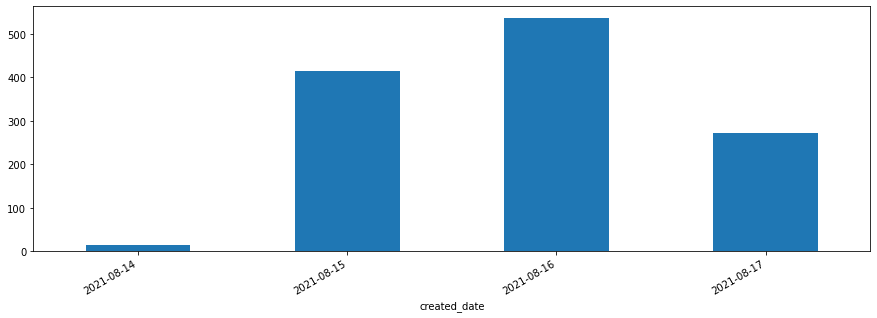

In [6]:
print("first post: " + str(min(submission_df['created_utc'])))
print("last post: " + str(max(submission_df['created_utc'])))

import matplotlib.dates as mdates
import matplotlib.pylab as plt
ax = submission_df[['created_date', 'id']].groupby('created_date').count().plot(kind='bar', figsize=(15,5),legend=None)
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()

Get comments on posts

In [7]:
idx = 2
print(submission_df[['id', 'author', 'title']].iloc[idx])
print(submission_df['full_link'].iloc[idx])
comments = list(api.search_comments(id = submission_df['id'][idx], limit=100))
comments_df = []
for comment in comments:
    comments_df.append(pd.DataFrame({'id': comment.id,
                                     'author': comment.author,
                                     'body': comment.body,
                                     'created_utc': comment.created_utc},
                                     index = [0]))
comments_df = pd.concat(comments_df)
comments_df['created_date'] = comments_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x).date())
comments_df.reset_index(inplace = True, drop = True)
comments_df[['id', 'body', 'created_date']]

id                                                   p4muxa
author                                          _blue_heat_
title     Afghanistan: What has the failed conflict cost...
Name: 2, dtype: object
https://www.reddit.com/r/politics/comments/p4muxa/afghanistan_what_has_the_failed_conflict_cost_the/


,id,body,created_date
0,h97lmyz,It looks like she’s eating him,2021-08-16
1,h97lmz0,Wondering the same,2021-08-16
2,h97lmz1,[deleted],2021-08-16
3,h97lmz2,Jus saying 🤤🤤🤤,2021-08-16
4,h97lmz3,Beep. Boop. I'm a robot.\nHere's a copy of \n\...,2021-08-16
...,...,...,...
95,h97lmxo,Except it’s your standard. You’re promoting ch...,2021-08-16
96,h97lmxp,"Remember once you find this place, you're here...",2021-08-16
97,h97lmxq,Normal,2021-08-16
98,h97lmxr,I love seeing this plant every time you post! ...,2021-08-16


## 2. Programmatically follow accounts to generate followers via follow-backs

In [8]:
redditor = reddit.redditor("amberlarsen1")

redditor.friend()
print("Is friend after friending?: " + str(redditor.is_friend))
friend_info = redditor.friend_info()
print("Friend Name: " + str(friend_info.name))
print("Comment Karma: " + str(friend_info.comment_karma))
print("Total Karma: " + str(friend_info.total_karma))

redditor.unfriend()
redditor = reddit.redditor("amberlarsen1")
print("\nIs friend after unfriending?: " + str(redditor.is_friend))

Is friend after friending?: True
Friend Name: amberlarsen1
Comment Karma: 2
Total Karma: 3

Is friend after unfriending?: False


## 3. Collect social network and profile information about individual users

In [22]:
author = comments_df['author'].tolist()[4]
author

'Reddit-Book-Bot'

In [21]:
for submission in reddit.redditor(author).submissions.new(limit=10):
    print(str(submission.subreddit) + ": " + submission.title.split("\n", 1)[0][:79])

u_Reddit-Book-Bot: We're looking for volunteers to write author bios or produce and upload books! 
u_Reddit-Book-Bot: Reddit-Book-Bot V 2.0| Information | F.A.Q | How To Use
u_Reddit-Book-Bot: Full List Of Books and Commands
FreeKarma4U: I will upvote this every comment. Comment away.
FreeKarma4U: Upvoting all comments! Please upvote mine too!
FreeKarma4U: Hello! I'm a new bot that posts free books and I need upvotes to work!🤖


In [20]:
for comment in reddit.redditor(author).comments.new(limit=10):
    print(str(comment.subreddit) + ": " + comment.body.split("\n", 1)[0][:79])

acnh: Beep. Boop. I'm a robot.
CrazyFuckingVideos: Beep. Boop. I'm a robot.
aaaaaaacccccccce: Beep. Boop. I'm a robot.
okbuddycapitalist: Beep. Boop. I'm a robot.
SHIBArmy: Beep. Boop. I'm a robot.
acnh: Beep. Boop. I'm a robot.
aaaaaaacccccccce: Beep. Boop. I'm a robot.
weeklyplanetpodcast: Beep. Boop. I'm a robot.
mississippi: Beep. Boop. I'm a robot.
BrighterThanCoruscant: Beep. Boop. I'm a robot.


## 4. Programmatically message users to rate the accuracy of a headline

In [23]:
user = reddit.redditor("dkoban")
print(user.name + ": " + str(user.total_karma))
user = reddit.redditor("nad_nabok")
print(user.name + ": " + str(user.total_karma))
user = reddit.redditor("amberlarsen1")
print(user.name + ": " + str(user.total_karma))

dkoban: 1
nad_nabok: 1
amberlarsen1: 3


In [24]:
reddit.redditor("amberlarsen1").message("Can you rate this?", 
                                        "Hi, I'm a bot.  Can you rate the accuracy of this headline? Thanks : )")

In [25]:
reddit.redditor("nad_nabok").message("Can you rate this?", 
                                        "Hi, I'm a bot.  Can you rate the accuracy of this headline? Thanks : )")

Is not working on other accounts.  It might be due to age of the account. Messaging also requires logging in.  

In [26]:
config.read("/Users/dankoban/Documents/Dissertation/config.ini")
client_id_bot = config['reddit']['client_id_bot']
client_secret_bot = config['reddit']['client_secret_bot']
user_agent_bot = config['reddit']['user_agent_bot']
password_bot = config['reddit']['password_bot']
username_bot = config['reddit']['username_bot']

bot = praw.Reddit(
    client_id=client_id_bot,
    client_secret=client_secret_bot,
    user_agent=user_agent_bot,
    username=username_bot,
    password=password_bot
)
username_bot

'nad_nabok'

In [27]:
bot.redditor("amberlarsen1").message("Can you rate this?", 
                                        "Hi, I'm a bot.  Can you rate the accuracy of this headline? Thanks : )")

RedditAPIException: RESTRICTED_TO_PM: "User doesn't accept direct messages. Try sending a chat request instead." on field 'to'